In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import requests
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device) 

True


In [9]:
class MaligaroDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes
    
df = yf.Ticker("AAPL").history(period="max")
e = torch.tensor(np.array(df))
e.device

device(type='cuda', index=0)

In [ ]:
# Define a simple neural network
class StockPriceModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StockPriceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# df = yf.Ticker("AAPL").history(period="max")
# Prepare the data
df['Return'] = df['Close'].pct_change()
df = df.dropna()
X = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
y = df['Return'].values

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

# Create dataset and dataloader
dataset = MaligaroDataSet(list(zip(X_tensor, y_tensor)))
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize the model, loss function, and optimizer
input_size = X.shape[1]
hidden_size = 128
output_size = 1
model = StockPriceModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

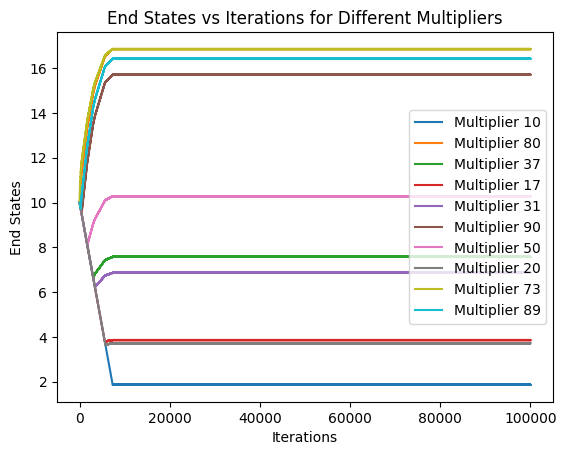

In [4]:
# 10x - 1 inhabitant
# 80x - 6 inhabitants
# 37x - 3 inhabitants
# 17x - 1 inhabitants
# 31x - 2 inhabitants
# 90x - 10 inhabitants
# 50x - 4 inhabitants
# 20x - 2 inhabitants
# 73x - 4 inhabitants
# 89x - 9 inhabitants

list_of_multipliers = [10, 80, 37, 17, 31, 90, 50, 20, 73, 89]
box_data = {10:1, 80:6, 37:3, 17:1, 31:2, 90:10, 50:4, 20:2, 73:4, 89:9}

def free_equation(percent_of_population,multiplier):
    return (10*multiplier)/(box_data[multiplier]+(percent_of_population))

def fee_equation(percent_of_population,multiplier):
    return (10*multiplier)/(box_data[multiplier]+(percent_of_population)) - 50

#o god im basically making an epoch batch thingy on my algo

wAHHHH = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=float)
steady_state = np.array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=float)

max_blah = 8

end_states = {10:[],80:[],37:[],17:[],31:[],90:[],50:[],20:[],73:[],89:[]}
end_multi = {10:[],80:[],37:[],17:[],31:[],90:[],50:[],20:[],73:[],89:[]}

x=0.01

for j in range(100000):
    for i in range(len(list_of_multipliers)):
        multi = list_of_multipliers[i]
        if i == max_blah:
            steady_state[i] = steady_state[i] + x
            wAHHHH[i] = free_equation(steady_state[i], multi)
        else:
            steady_state[i] = steady_state[i] - x/9
            wAHHHH[i] = free_equation(steady_state[i], multi)
        end_multi[multi] = np.append(end_multi[multi],wAHHHH[i])
        end_states[multi] = np.append(end_states[multi],steady_state[i])
    max_blah = np.argmax(wAHHHH)

# print("End states: ", end_states)
# print("End multipliers: ", end_multi)
        
for key in end_states:
    plt.plot(end_states[key], label=f"Multiplier {key}")

plt.legend()
plt.xlabel("Iterations")
plt.ylabel("End States")
plt.title("End States vs Iterations for Different Multipliers")
plt.show()


In [5]:
expected_return = []
for i in range(len(list_of_multipliers)):
    percent_of_population = steady_state[i]
    expected_return = np.append(expected_return, free_equation(percent_of_population, list_of_multipliers[i]))
print("Expected return: ", expected_return)


Expected return:  [35.01945525 35.00243072 34.9789916  35.01144165 35.00627353 35.00432152
 34.99222395 34.95145631 35.00266383 35.00874126]


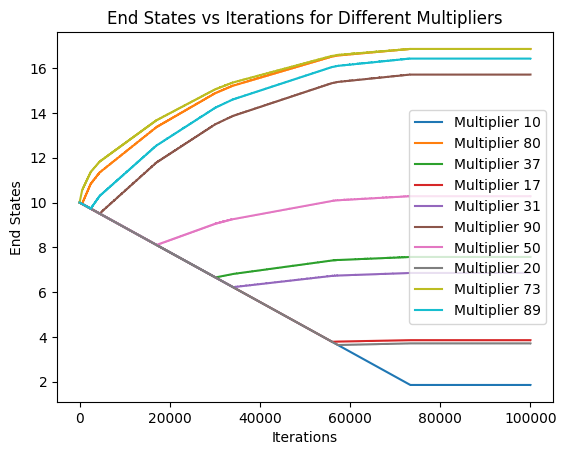

In [38]:
# 10x - 1 inhabitant
# 80x - 6 inhabitants
# 37x - 3 inhabitants
# 17x - 1 inhabitants
# 31x - 2 inhabitants
# 90x - 10 inhabitants
# 50x - 4 inhabitants
# 20x - 2 inhabitants
# 73x - 4 inhabitants
# 89x - 9 inhabitants

list_of_multipliers = [10, 80, 37, 17, 31, 90, 50, 20, 73, 89]

def free_equation(percent_of_population,multiplier):
    box_data = {10:1, 80:6, 37:3, 17:1, 31:2, 90:10, 50:4, 20:2, 73:4, 89:9}
    return (10*multiplier)/(box_data[multiplier]+(percent_of_population))

def fee_equation(percent_of_population,multiplier):
    box_data = {10:1, 80:6, 37:3, 17:1, 31:2, 90:10, 50:4, 20:2, 73:4, 89:9}
    return (10*multiplier)/(box_data[multiplier]+(percent_of_population)) - 50

#o god im basically making an epoch batch thingy on my algo

wAHHHH = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=float)
steady_state = np.array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=float)

max_blah = 8

end_states = {10:[],80:[],37:[],17:[],31:[],90:[],50:[],20:[],73:[],89:[]}
end_multi = {10:[],80:[],37:[],17:[],31:[],90:[],50:[],20:[],73:[],89:[]}

x=0.001

for j in range(100000):
    for i in range(len(list_of_multipliers)):
        multi = list_of_multipliers[i]
        if i == max_blah:
            steady_state[i] = steady_state[i] + x
            wAHHHH[i] = fee_equation(steady_state[i], multi)
        else:
            steady_state[i] = steady_state[i] - x/9
            wAHHHH[i] = fee_equation(steady_state[i], multi)
        end_multi[multi] = np.append(end_multi[multi],wAHHHH[i])
        end_states[multi] = np.append(end_states[multi],steady_state[i])
    max_blah = np.argmax(wAHHHH)

# print("End states: ", end_states)
# print("End multipliers: ", end_multi)
        
for key in end_states:
    plt.plot(end_states[key], label=f"Multiplier {key}")

plt.legend()
plt.xlabel("Iterations")
plt.ylabel("End States")
plt.title("End States vs Iterations for Different Multipliers")
plt.show()


In [7]:
expected_return = []
for i in range(len(list_of_multipliers)):
    percent_of_population = steady_state[i]
    expected_return = np.append(expected_return, fee_equation(percent_of_population, list_of_multipliers[i]))
print("Expected return: ", expected_return)

print(steady_state)



Expected return:  [-14.98054475 -14.99756928 -15.0210084  -14.98855835 -14.99372647
 -14.99567848 -15.00777605 -15.04854369 -14.99733617 -14.99125874]
[ 1.85555556 16.85555556  7.57777778  3.85555556  6.85555556 15.71111111
 10.28888889  3.72222222 16.85555556 16.42222222]
